In [1]:
#!pip install rasterio

In [2]:
#!pip install gdal

In [3]:
import os
import numpy as np
#from osgeo import gdal, gdal_array, ogr
import rasterio as rio
import pandas as pd
import pickle
import cubist
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer

In [4]:
# Function to calculate first-order differences of spectra
def fod (spectra):
    fo_spec = spectra.iloc[:,:]
    (row,col) = fo_spec.shape
    
    for i in range(0, col):
        if i==col-1:
            fo_spec.iloc[:,i] = fo_spec.iloc[:,i-1]
        else:    
            fo_spec.iloc[:,i] = (spectra.iloc[:,i+1]- spectra.iloc[:,i])
    return fo_spec

# Worker function for parallel predictions
def worker(arr):
    return model.predict(arr)

# Function to make parallel predictions
def make_parallel_predictions(model, X):
    num_processes = mp.cpu_count()
    chunk_size = int(X.shape[0] / num_processes)
    chunks = [X[i:i + chunk_size] for i in range(0, X.shape[0], chunk_size)]

    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(worker, chunks)

    y_pred = np.concatenate(results, axis=0)
    return y_pred

In [40]:
## VENuS Image
# fname = './VE_VM03_VSC_L2VALD_ISRAELWI_20220824/VE_VM03_VSC_L2VALD_ISRAELWI_20220824.DBL.DIR/VE_VM03_VSC_PDTIMG_L2VALD_ISRAELWI_20220824_SRE.DBL.TIF'
# fname = 'VE_VM03_VSC_L2VALD_ISRAELWI_20220824_Clip.tif'

# src = rio.open(fname)
# metadata = src.meta
# num_bands = src.count

# venus_image = []

# for i in range(num_bands):
#     image = src.read(i + 1)
#     image = image.astype(float)
#     image[image < 0] = np.nan
#     image = image / 1000
#     image[image < 0] = np.nan
#     venus_image.append(image.flatten())

# venus_image = np.array(venus_image).T

In [93]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fname = 'VE_VM03_VSC_L2VALD_ISRAELWI_20220824_Clip.tif'

src = rio.open(fname)
metadata = src.meta
num_bands = src.count

venus_image = []

for i in range(num_bands):
    image = src.read(i+1)
    image = image.astype(float)
    #image[image < 0] = np.nan
    image = image / 1000
    image[image < 0] = np.nan
    venus_image.append(image.flatten())
    # has_nan = np.isnan(image).sum()
    # print('has_nan:', has_nan)

venus_image = np.array(venus_image).T
    
  

In [94]:
venus_image

array([[0.095, 0.123, 0.153, ..., 0.248, 0.27 , 0.277],
       [0.095, 0.121, 0.149, ..., 0.245, 0.268, 0.275],
       [0.085, 0.119, 0.146, ..., 0.247, 0.269, 0.272],
       ...,
       [0.069, 0.088, 0.112, ..., 0.253, 0.275, 0.277],
       [0.072, 0.086, 0.111, ..., 0.261, 0.282, 0.287],
       [0.063, 0.087, 0.11 , ..., 0.27 , 0.293, 0.299]])

In [95]:
venus_df = pd.DataFrame(venus_image)
venus_df.columns = ['420', '443', '490', '555', '619', '638', '672', '702', '742', '782', '865', '910']
venus_df.drop('619', axis=1, inplace=True)

In [96]:
nan_indices = venus_df.index[venus_df.isna().any(axis=1)]

In [97]:
nan_indices

Index([  34274,   36099,   52544,   65278,   65339,  151520,  151521,  151522,
        151524,  151525,  153345,  153346,  548901, 1094451, 1251341, 1253166,
       1351772, 1443034, 1846379, 1857335, 1857336, 1859160, 1859161, 1864633,
       1866459, 1868284, 1871933, 1926689, 1926690, 1943115, 1980719, 1980764,
       2026386, 2028219, 2029996, 2051898, 2051899, 2053734, 2053735, 2059207,
       2059236, 2061060, 2086589, 2097569, 2134051, 2135877, 2143184, 2287427,
       2302029, 2303827, 2307487, 2353144, 2384179, 2576221, 2576222, 2706146,
       2732143, 3050098, 3055578, 3111656, 3121287, 3122603, 3123112, 3124428,
       3126253, 3126752, 3128077, 3128542, 3128543, 3129884, 3129902, 3131726,
       3131727, 3131728, 3132231, 3133551, 3134081, 3135352, 3135353, 3137177],
      dtype='int64')

In [98]:
df = venus_df.ffill().bfill()

In [100]:
df.index[df.isna().any(axis=1)]

Index([], dtype='int64')

In [83]:
for i in range(num_bands):
    image = src.read(i+1)
    image = image.astype(float)
    image[image < 0] = np.nan
    has_nan = np.isnan(image).sum()
    print('has_nan:', has_nan)
    

has_nan: 80
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0
has_nan: 0


has_nan: 0


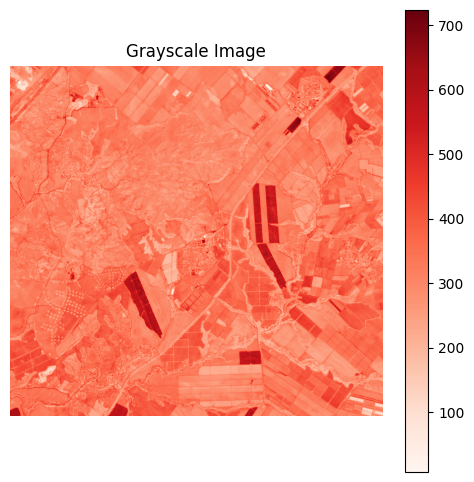

In [ ]:
plt.figure(figsize=(6, 6))  # Adjust figure size as needed
# Define custom colormap resembling clay colors
# colors = ['#8B4513', '#CD853F', '#DEB887']  # Brown tones
# clay_cmap = ListedColormap(colors)

image = src.read(11)
image = image.astype(float)

# nan_indices = venus_df.index[venus_df.isna().any(axis=1)]
# print('nan_inx:', nan_indices)

has_nan = np.isnan(image).sum()
print('has_nan:', has_nan)

my_cmap = plt.cm.Reds.copy()
my_cmap.set_bad(color='green')

plt.imshow(image, cmap = my_cmap)
plt.colorbar()  # Optional: Display color bar to show intensity scale
plt.title('Grayscale Image')  # Optional: Add a title
plt.axis('off')  # Optional: Hide axis values
plt.show()

In [ ]:
for i in range(num_bands):
    image = src.read(i + 1)
    image = image.astype(float)
    image[image < 0] = np.nan
    image = image / 1000
    image[image < 0] = np.nan
    venus_image.append(image.flatten())

In [10]:
has_nan = np.isnan(venus_image).any()
has_nan

True

In [11]:
np.isnan(venus_image).sum()

80

In [16]:
nan_mask = np.isnan(venus_image)

In [17]:
nan_indices = np.where(nan_mask)[0]

In [19]:
nan_indices.shape

(80,)

In [5]:
halt here

SyntaxError: invalid syntax (3817168042.py, line 1)

In [ ]:
# Function to preprocess input data based on soil property
def get_process_func(soil_property):
    if soil_property == 'caco3' or soil_property == 'toc':
        return lambda df: fod((1 / df).apply(np.log))
    else:
        return lambda df: fod(df)

# Function to get appropriate model based on soil property
def get_model_dump(soil_property):
    if soil_property == 'caco3':
        return './models/CaCO3_model_cubist.pkl'
    elif soil_property == 'clay':
        return './models/clay_model_cubist.pkl'
    elif soil_property == 'toc':
        return './models/TOC_model_cubist.pkl'
    elif soil_property == 'silt':
        return './models/silt_model_gbrt.pkl'
    elif soil_property == 'sand':
        return './models/sand_model_gbrt.pkl'

# Function to predict soil property using pre-trained model
def predict_soil_property(soil_property, venus_df_cleaned):
    imputer = SimpleImputer(strategy='mean')
    process_func = get_process_func(soil_property)
    process2 = process_func(venus_df_cleaned)
    process2.replace([np.inf, -np.inf], np.nan, inplace=True)
    x_pred = pd.DataFrame(imputer.fit_transform(process2), columns=process2.columns)
    print(f'Model loaded for {soil_property}')
    dumpName = get_model_dump(soil_property)
    model = pickle.load(open(dumpName, 'rb'))
    return model.predict(x_pred)

In [ ]:
venus_df = pd.DataFrame(venus_image)
venus_df.columns = ['420', '443', '490', '555', '619', '638', '672', '702', '742', '782', '865', '910']
venus_df.drop('619', axis=1, inplace=True)

In [ ]:
# 1. Remove NaN values from the dataframe
nan_indices = venus_df.index[venus_df.isna().any(axis=1)]
venus_df_cleaned = venus_df.dropna()

In [ ]:
# Initialize DataFrame with all five soil properties
df = pd.DataFrame(index=venus_df_cleaned.index)

In [ ]:
# Define soil properties
soil_properties = ['caco3', 'clay', 'toc', 'silt', 'sand']

# Predict each soil property and store in DataFrame
for soil_property in soil_properties:
    y_pred = predict_soil_property(soil_property, venus_df_cleaned)
    df[soil_property] = y_pred

In [ ]:
#Print or further process the DataFrame as needed
print(df)

In [ ]:
# Printing minimum and maximum values of caco3 in the predictions
minimum_value = df['caco3'].min()
maximum_value = df['caco3'].max()

print(f"Minimum value: {minimum_value}")
print(f"Maximum value: {maximum_value}")

In [ ]:
# Printing minimum and maximum values of clay in the predictions
minimum_value = df['clay'].min()
maximum_value = df['clay'].max()

print(f"Minimum value: {minimum_value}")
print(f"Maximum value: {maximum_value}")

In [ ]:
# Printing minimum and maximum values of toc in the predictions
minimum_value = df['toc'].min()
maximum_value = df['toc'].max()

print(f"Minimum value: {minimum_value}")
print(f"Maximum value: {maximum_value}")

In [ ]:
# Printing minimum and maximum values of silt in the predictions
minimum_value = df['silt'].min()
maximum_value = df['silt'].max()

print(f"Minimum value: {minimum_value}")
print(f"Maximum value: {maximum_value}")

In [ ]:
# Printing minimum and maximum values of sand in the predictions
minimum_value = df['sand'].min()
maximum_value = df['sand'].max()

print(f"Minimum value: {minimum_value}")
print(f"Maximum value: {maximum_value}")

In [ ]:
y_pred = y_pred.flatten()
predicted_image = y_pred.reshape(metadata['height'], metadata['width'])
predicted_image = np.where(np.isnan(predicted_image), 0, predicted_image)
predicted_image = np.expand_dims(predicted_image, axis=0)
model_name = dumpName.split('.pkl')[0].split('_')[-1]
output_path = f'./results/20220824_Clip_Predicted_{model_name}_{soil_property}.tif'
output_image = rio.open(output_path, 'w', driver = 'GTiff', dtype = 'float32', crs = src.crs, width=metadata['width'], height=metadata['height'], count=1, transform = src.transform)
output_image.write(predicted_image)
output_image.close()

print("Predicted results saved :", output_path)